#Netflix Content Analysis


The goal of this analysis is to explore Netflix's content library (Movies and TV Shows) and understand any trends and patterns. This analysis also includes a text and sentiment analysis on the descriptions included for each piece of content. Lastly, we conclude with a basic recommendation system that can suggest shows and movies to users based on content descriptions.

This Kaggle data set consists of 8,807 rows of data and includes features such as content type, title, director, cast, country, release year, and description, among others.

##Imports and Set-Up

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Load Data and Data Cleaning

In [3]:
# Read data
df = pd.read_csv('netflix_titles.csv')

In [4]:
# View data
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
# View data types of columns
df_dtypes = df.dtypes.reset_index()
df_dtypes.columns = ['column', 'column_dtype']
df_dtypes

,column,column_dtype
0,show_id,object
1,type,object
2,title,object
3,director,object
4,cast,object
5,country,object
6,date_added,object
7,release_year,int64
8,rating,object
9,duration,object


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [7]:
# Check for duplicate entries
df.duplicated().sum()

0

In [8]:
total_entries = len(df)
missing_percentages = (df.isnull().sum() / total_entries) * 100
missing_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': missing_percentages})

# Sort by percent_missing (missing entries by column) in descending order
missing_df_sorted = missing_df.sort_values(by='percent_missing', ascending=False)
missing_df_sorted

,column_name,percent_missing
director,director,29.908028
country,country,9.435676
cast,cast,9.367549
date_added,date_added,0.113546
rating,rating,0.045418
duration,duration,0.034064
show_id,show_id,0.000000
type,type,0.000000
title,title,0.000000
release_year,release_year,0.000000


After checking for the percentage of entries missing from each column in the data set, we can see that the director, country, cast, date added, rating, and duration columns all have missing values that need to be taken into consideration.

In [9]:
# Handle missing values
df['director'].fillna(value = 'Director Not Available', inplace = True)
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['cast'].fillna(value = 'Cast Not Available', inplace = True)
df['rating'].fillna(value = 'Rating Not Available', inplace = True)
df.dropna(inplace = True)
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Missing values were filled in and remaining entries where missing values could not be replaced appropriately were dropped from the dataframe.

In [10]:
# Strip any leading or trailing whitespace
df['date_added'] = df['date_added'].str.strip()

# Convert date_added column to datetime
df['date'] = pd.to_datetime(df['date_added'], dayfirst = True, format = 'mixed')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,date
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Cast Not Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09-25
1,s2,TV Show,Blood & Water,Director Not Available,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09-24
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09-24
3,s4,TV Show,Jailbirds New Orleans,Director Not Available,Cast Not Available,United States,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09-24
4,s5,TV Show,Kota Factory,Director Not Available,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09-24


In [11]:
# Remove extra leading or trailing commas for entries in country column
df['country'] = df['country'].str.strip(', ')

We strip any trailing or leading whitespace/commas that are not needed in the country and date added columns. We also convert the date_added column to the datetime type.

## Exploratory Data Analysis

In [12]:
# Count of content released in each year broken down by content type
release_year_df = df[['release_year', 'type']]
release_year_df = release_year_df.groupby(['release_year', 'type']).size().reset_index(name = 'count')

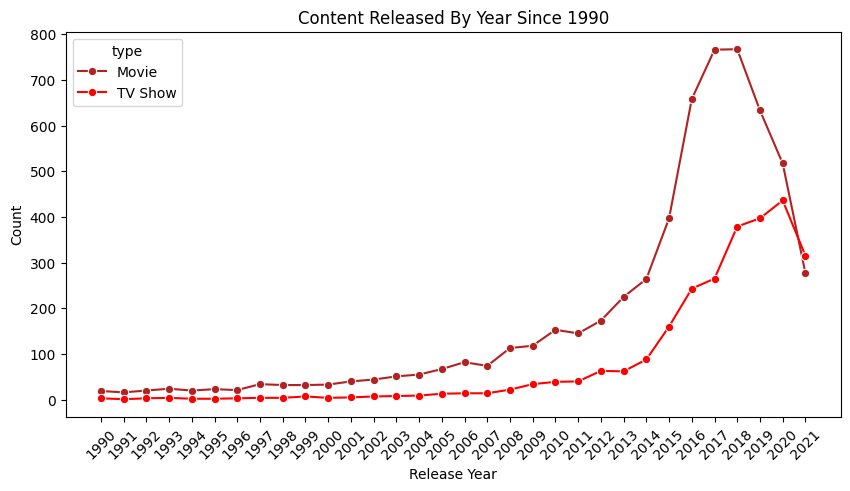

In [13]:
# Content of content by type since 2000
release_df = release_year_df[release_year_df['release_year'] >= 1990]

fig = plt.subplots(figsize = (10,5))
sns.lineplot(data = release_df, x = 'release_year', y = 'count', hue = 'type', marker = 'o', palette = ['firebrick', 'red'])
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(np.arange(1990, 2022), rotation = 45)
plt.title('Content Released By Year Since 1990')
plt.grid(visible=False)
plt.show()

The amount of new movie content released peaked in 2017 while new TV show content peaked in 2020.

In [14]:
# Breakdown of all content by type
type_df = df['type'].value_counts().reset_index()
type_df.columns = ['type', 'count']

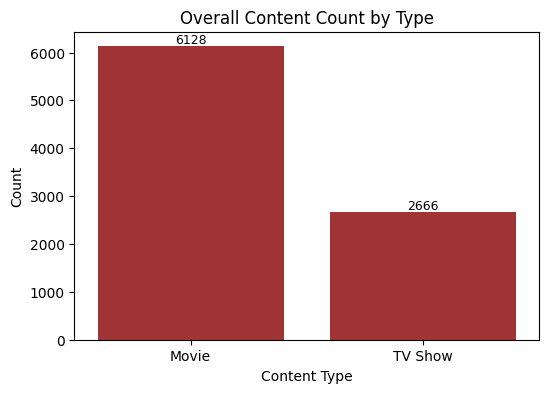

In [15]:
# Plot for overall content count by type
fig = plt.subplots(figsize = (6,4))
ax = sns.barplot(data = type_df, x = 'type', y = 'count', color = 'firebrick')
ax.bar_label(ax.containers[0], fontsize = 9)
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.title('Overall Content Count by Type')
plt.grid(visible=False)
plt.show()

Despite growth in TV shows, the amount of movie content remains substantially higher than TV show content.

In [16]:
# Breakdown of content type by country
country_df = df[['country', 'type']]
country_df['country'] = country_df['country'].str.split(', ')
country_df = country_df.explode('country')
country_df = country_df.groupby(['country', 'type']).size().reset_index(name = 'count')
country_df.sort_values(by = 'country', inplace = True)

<ipython-input-16-e3c96caae839>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df['country'] = country_df['country'].str.split(', ')


In [17]:
# Top 10 countries in terms of amount of movie content
country_movies_df = country_df[country_df['type'] == 'Movie']
country_movies_df.sort_values(by = 'count', ascending = False, inplace = True)
top_10_country_movies_df = country_movies_df[0:10]

<ipython-input-17-1c47621794ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_movies_df.sort_values(by = 'count', ascending = False, inplace = True)


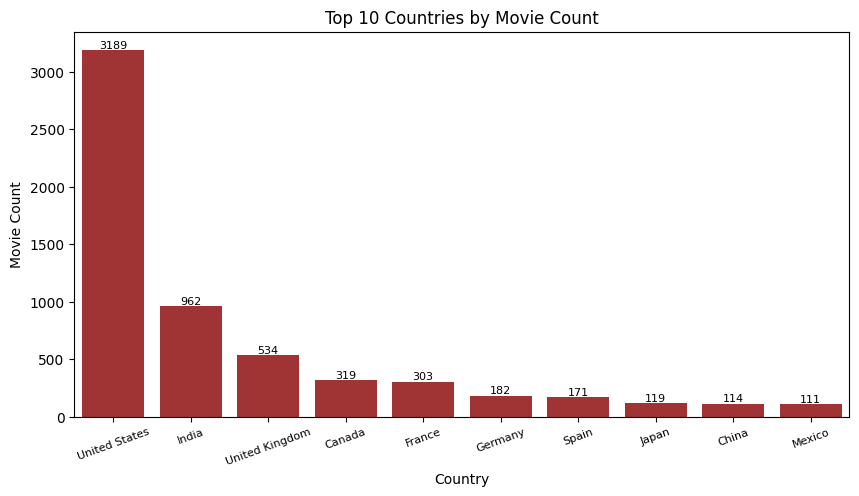

In [18]:
# Plot for top 10 countries by movie count
fig = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = top_10_country_movies_df, x = 'country', y = 'count', color = 'firebrick')
ax.bar_label(ax.containers[0], fontsize = 8)
plt.xlabel('Country')
plt.ylabel('Movie Count')
plt.xticks(fontsize = 8, rotation = 20)
plt.title('Top 10 Countries by Movie Count')
plt.grid(visible=False)
plt.show()

The number of movies released by the United States is significantly higher than the rest of the world, followed by India and the UK.

In [19]:
# Top 10 countries in terms of amount of TV show content
country_shows_df = country_df[country_df['type'] == 'TV Show']
country_shows_df.sort_values(by = 'count', ascending = False, inplace = True)
top_10_country_shows_df = country_shows_df[0:10]

<ipython-input-19-b4562ac726cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_shows_df.sort_values(by = 'count', ascending = False, inplace = True)


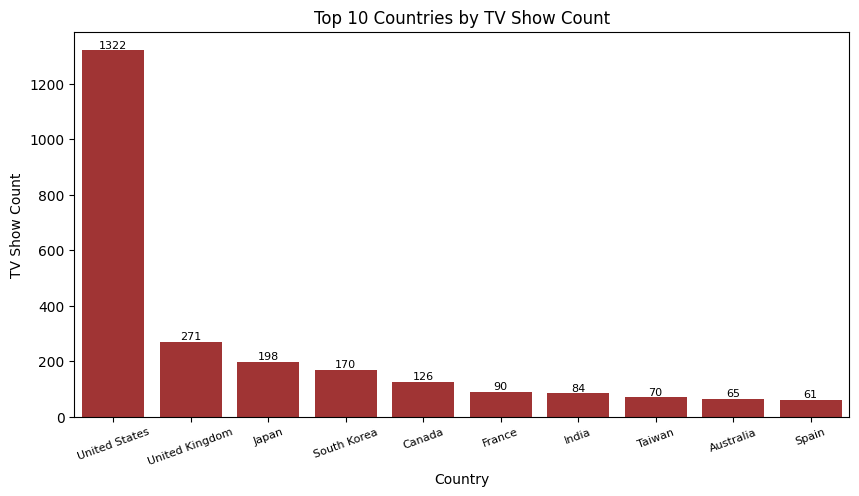

In [20]:
# Plot for top 10 countries by TV show count
fig = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = top_10_country_shows_df, x = 'country', y = 'count', color = 'firebrick')
ax.bar_label(ax.containers[0], fontsize = 8)
plt.xlabel('Country')
plt.ylabel('TV Show Count')
plt.xticks(fontsize = 8, rotation = 20)
plt.title('Top 10 Countries by TV Show Count')
plt.grid(visible=False)
plt.show()

The number of TV shows released by the United States is significantly higher than the rest of the world, followed by the UK and Japan.

In [21]:
# New content added by month
month_df = df.copy()
month_df['month_added'] = month_df['date'].dt.month
content_by_month_df = month_df.groupby('month_added').size().reset_index(name = 'count')

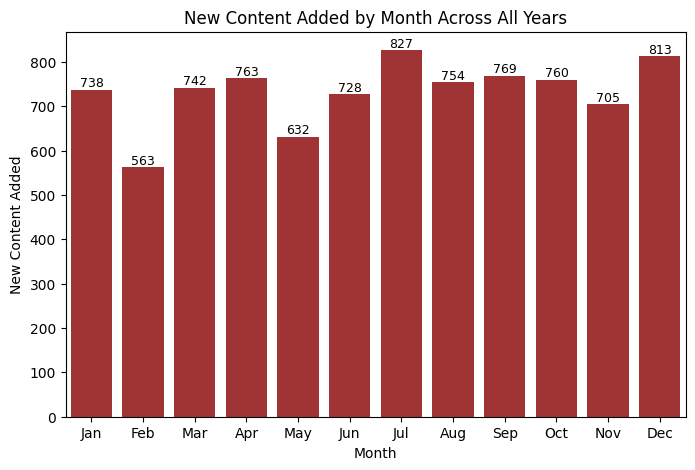

In [22]:
# Plot for amount of new content added by month
fig = plt.subplots(figsize = (8,5))
ax = sns.barplot(data = content_by_month_df, x = 'month_added', y = 'count', color = 'firebrick')
ax.bar_label(ax.containers[0], fontsize = 9)
plt.xlabel('Month')
plt.ylabel('New Content Added')
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('New Content Added by Month Across All Years')
plt.grid(visible=False)
plt.show()

July and December have had the most new content additions across all years that we have data available for coinciding with the summer and holiday seasons.

In [23]:
# Looking at Top Directors
directors_df = df[df['director'] != 'Director Not Available']
director_count_df = directors_df['director'].value_counts().to_frame().reset_index()
director_count_df

,director,count
0,Rajiv Chilaka,19
1,"Raúl Campos, Jan Suter",18
2,Suhas Kadav,16
3,Marcus Raboy,16
4,Jay Karas,14
...,...,...
4522,"Raymie Muzquiz, Stu Livingston",1
4523,Joe Menendez,1
4524,Eric Bross,1
4525,Will Eisenberg,1


## Text Analysis

We start by tokenizing the text from the descriptions, converting to lowercase, and removing any stopwords.

### Preprocessing of Text

In [24]:
# Get stop words
stop_words = set(stopwords.words('english'))

In [25]:
# Preprocessing of text
def process_content(description):
  tokens = word_tokenize(description)
  tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  text = ' '.join(lemmatized_tokens)
  return text

In [26]:
# Apply preprocessing to descriptions
df['processed_description'] = df['description'].apply(process_content)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,date,processed_description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Cast Not Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09-25,father nears end life filmmaker kirsten johnso...
1,s2,TV Show,Blood & Water,Director Not Available,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09-24,crossing path party cape town teen set prove w...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09-24,protect family powerful drug lord skilled thie...
3,s4,TV Show,Jailbirds New Orleans,Director Not Available,Cast Not Available,United States,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09-24,feud flirtation toilet talk go among incarcera...
4,s5,TV Show,Kota Factory,Director Not Available,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09-24,city coaching center known train india finest ...


### Sentiment Analysis

In [27]:
# Sentiment Analysis using NLTK
sentiment_analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores
def sentiment_score(text):
  scores = sentiment_analyzer.polarity_scores(text)
  return scores

In [28]:
# Assign positive, negative, or neutral sentiment based on assigned compound score
def sentiment_cat(score):
  if score >= 0.05:
    return 'Positive'
  elif score <= -0.05:
    return 'Negative'
  else:
    return 'Neutral'

In [29]:
# Assign compound scores to each description
sentiment_df = df.copy()
sentiment_df['sentiment_scores'] = sentiment_df['processed_description'].apply(sentiment_score)
sentiment_df['compound'] = sentiment_df['sentiment_scores'].apply(lambda x: x['compound'])
sentiment_df['sentiment_category'] = sentiment_df['compound'].apply(sentiment_cat)
sentiment_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,date,processed_description,sentiment_scores,compound,sentiment_category
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Cast Not Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09-25,father nears end life filmmaker kirsten johnso...,"{'neg': 0.199, 'neu': 0.663, 'pos': 0.138, 'co...",-0.2960,Negative
1,s2,TV Show,Blood & Water,Director Not Available,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09-24,crossing path party cape town teen set prove w...,"{'neg': 0.183, 'neu': 0.667, 'pos': 0.15, 'com...",-0.1531,Negative
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09-24,protect family powerful drug lord skilled thie...,"{'neg': 0.49, 'neu': 0.331, 'pos': 0.179, 'com...",-0.8860,Negative
3,s4,TV Show,Jailbirds New Orleans,Director Not Available,Cast Not Available,United States,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09-24,feud flirtation toilet talk go among incarcera...,"{'neg': 0.112, 'neu': 0.605, 'pos': 0.284, 'co...",0.5719,Positive
4,s5,TV Show,Kota Factory,Director Not Available,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09-24,city coaching center known train india finest ...,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",0.7579,Positive


We assign a sentiment (Positive, Negative, or Neutral) to each description based on the computed compound score.

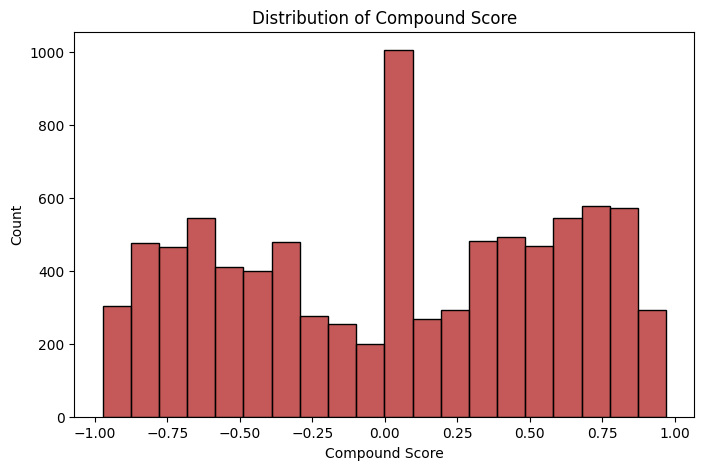

In [30]:
# Distribution of compound sentiment score
fig = plt.subplots(figsize = (8,5))
sns.histplot(data = sentiment_df, x = 'compound', color = 'firebrick')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.title('Distribution of Compound Score')
plt.grid(visible=False)
plt.show()

In [31]:
# Sentiment Score over the years
sentiment_over_time_df = sentiment_df.copy()
sentiment_over_time_df.sort_values(by = 'date', inplace = True)
sentiment_over_time_df = sentiment_over_time_df.set_index('date')
sentiment_over_time_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,processed_description,sentiment_scores,compound,sentiment_category
date,,,,,,,,,,,,,,,,
2008-01-01,s5958,Movie,To and From New York,Sorin Dan Mihalcescu,"Barbara King, Shaana Diya, John Krisiukenas, Y...",United States,"January 1, 2008",2006,TV-MA,81 min,"Dramas, Independent Movies, Thrillers","While covering a story in New York City, a Sea...",covering story new york city reporter uncovers...,"{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'comp...",-0.2960,Negative
2008-02-04,s6612,TV Show,Dinner for Five,Director Not Available,Cast Not Available,United States,"February 4, 2008",2007,TV-MA,1 Season,Stand-Up Comedy & Talk Shows,"In each episode, four celebrities join host Jo...",episode four celebrity join host jon favreau d...,"{'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...",0.5267,Positive
2009-05-05,s5957,Movie,Just Another Love Story,Ole Bornedal,"Anders W. Berthelsen, Rebecka Hemse, Nikolaj L...",Denmark,"May 5, 2009",2007,TV-MA,104 min,"Dramas, International Movies",When he causes a car accident that leaves a yo...,cause car accident leaf young woman amnesia ma...,"{'neg': 0.157, 'neu': 0.657, 'pos': 0.187, 'co...",0.1531,Positive
2009-11-18,s5956,Movie,Splatter,Joe Dante,"Corey Feldman, Tony Todd, Tara Leigh, Erin Way...",United States,"November 18, 2009",2009,TV-MA,29 min,Horror Movies,"After committing suicide, a washed-up rocker r...",committing suicide rocker return grave torment...,"{'neg': 0.603, 'neu': 0.326, 'pos': 0.071, 'co...",-0.8957,Negative
2010-11-01,s7371,Movie,Mad Ron's Prevues from Hell,Jim Monaco,"Nick Pawlow, Jordu Schell, Jay Kushwara, Micha...",United States,"November 1, 2010",1987,NR,84 min,"Cult Movies, Horror Movies","This collection cherry-picks trailers, forgott...",collection trailer forgotten scene poster art ...,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.2263,Negative


In [32]:
# Average compound score of descriptions by year
annual_sentiment_df = sentiment_over_time_df.resample('Y')['compound'].mean().reset_index()
annual_sentiment_df = annual_sentiment_df.rename(columns = {'compound': 'average_sentiment'})
annual_sentiment_df['year'] = annual_sentiment_df['date'].dt.year
annual_sentiment_df

,date,average_sentiment,year
0,2008-12-31,0.115350,2008
1,2009-12-31,-0.371300,2009
2,2010-12-31,-0.226300,2010
3,2011-12-31,-0.264523,2011
4,2012-12-31,0.285933,2012
5,2013-12-31,0.243036,2013
6,2014-12-31,0.196913,2014
7,2015-12-31,0.125317,2015
8,2016-12-31,0.042055,2016
9,2017-12-31,0.017252,2017


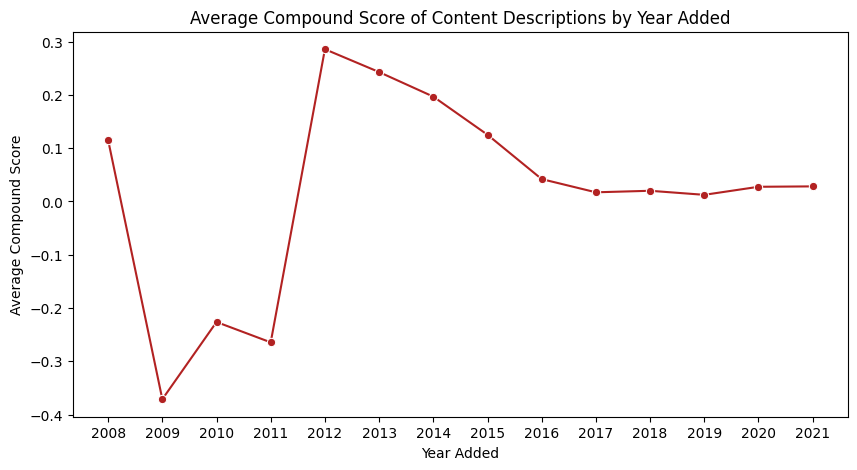

In [33]:
# Plot of Avg. Compound Score for Description by year that content was added
fig = plt.subplots(figsize = (10,5))
sns.lineplot(data = annual_sentiment_df, x = 'year', y = 'average_sentiment', marker = 'o', color = 'firebrick')
plt.xlabel('Year Added')
plt.ylabel('Average Compound Score')
plt.title('Average Compound Score of Content Descriptions by Year Added')
plt.xticks(np.arange(2008, 2022))
plt.grid(visible=False)
plt.show()

We look at the average compound score by year which was at its lowest in 2009 and at its highest in 2012. Over the years, the average sentiment has increased and flattened out in recent years.

In [34]:
# Sentiment Category By Year of Content Addition
sentiment_category_df = sentiment_df.copy()
sentiment_category_df['year_added'] = sentiment_category_df['date'].dt.year

In [35]:
category_count_df = sentiment_category_df[['year_added', 'sentiment_category']]
category_count_df = category_count_df.groupby(['year_added', 'sentiment_category']).size().reset_index(name = 'count')
category_count_df = category_count_df[category_count_df['year_added'] >= 2015]
category_count_df

,year_added,sentiment_category,count
16,2015,Negative,25
17,2015,Neutral,8
18,2015,Positive,49
19,2016,Negative,182
20,2016,Neutral,33
21,2016,Positive,212
22,2017,Negative,496
23,2017,Neutral,152
24,2017,Positive,539
25,2018,Negative,691


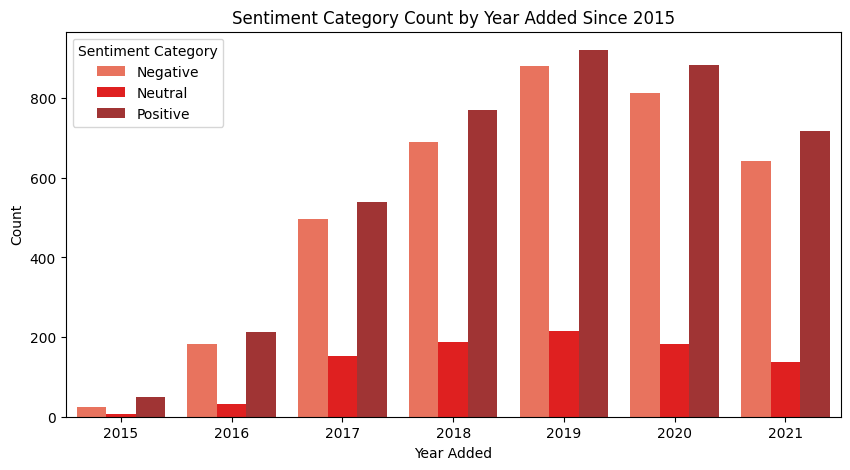

In [36]:
# Plot for sentiment category count by year the content was added (since 2015)
fig = plt.subplots(figsize = (10,5))
sns.barplot(data = category_count_df, x = 'year_added', y = 'count', hue = 'sentiment_category', palette = {'Positive': 'firebrick', 'Neutral': 'red', 'Negative': 'tomato'})
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.title('Sentiment Category Count by Year Added Since 2015')
plt.legend(title = 'Sentiment Category')
plt.grid(visible=False)
plt.show()

The number of descriptions with positive or negative sentiment have remained fairly close across the years, with positive sentiment descriptions slightly higher.

In [37]:
sentiment_df['sentiment_category'].value_counts()

sentiment_category
Positive    4118
Negative    3753
Neutral      923
Name: count, dtype: int64

###Word Cloud

In [38]:
# Filter for all US movies
us_movies_df = df[(df['type'] == 'Movie') & (df['country'] == 'United States')]
us_movies_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,date,processed_description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Cast Not Available,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09-25,father nears end life filmmaker kirsten johnso...
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",United States,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,2021-09-24,equestria divided hero belief earth pony pegas...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,2021-09-24,woman adjusting life loss contends feisty bird...
13,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,"Klara Castanho, Lucca Picon, Júlia Gomes, Marc...",United States,"September 22, 2021",2021,TV-PG,91 min,"Children & Family Movies, Comedies",When the clever but socially-awkward Tetê join...,2021-09-22,clever tetê join new school anything fit queen...
16,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",Cast Not Available,United States,"September 22, 2021",2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...,2021-09-22,declassified document reveal life otto skorzen...


In [39]:
# Convert descriptions for US movies to a list
us_movies_descriptions = us_movies_df['processed_description'].tolist()
# Split each sentence into words
description_tokens = [i.split() for i in us_movies_descriptions]
# Flatten out the list of words
description_tokens = [j for i in description_tokens for j in i]
# Remove punctuation
description_tokens = [i for i in description_tokens if i.isalpha()]

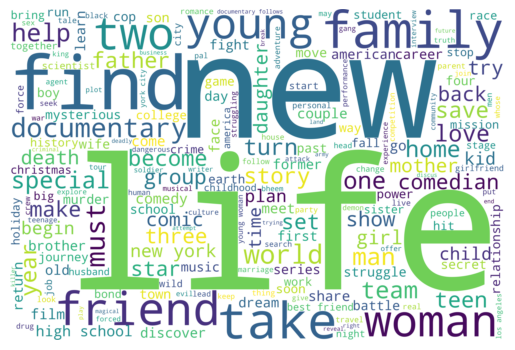

In [40]:
# Generate word cloud for descriptions associated with US movies
word_string = " ".join(description_tokens)
wordcloud = WordCloud(width = 6000, height = 4000, min_font_size = 10, background_color = 'white').generate(word_string)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Based on this word cloud for descriptions of United States movies, we can see that "life", "find", "new", and "family" are some of the most commonly used words.

##Recommendation System

We will now build a recommendation system by computing similarity scores based on the content descriptions provided in the data set. We will use cosine similarity to compute the similarity scores.

In [41]:
# Use TF-IDF to put descriptions in format to compute similarity
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_description'])

In [42]:
# Use cosine similarity to compute similarity scores
cosine_sim = cosine_similarity(X, X)

In [43]:
cosine_sim_df = pd.DataFrame(cosine_sim)

In [44]:
def get_recommendations(title, cosine_sim_df, df):

    # Get the index of the movie/show based on title provided
    idx = df.index[df['title'] == title].tolist()[0]

    # Get similarity scores with respect to the target movie/show
    similarity = list(enumerate(cosine_sim_df.loc[idx]))

    # Sort based on the similarity scores
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 5 most similar movies
    top_indices = [i[0] for i in similarity[1:6]]

    # Return the titles of the top recommended movies
    return df.loc[top_indices, 'title']

We find the top 5 most similar movies based on the similarity scores that were computed.

In [45]:
recommendations = get_recommendations('Dick Johnson Is Dead', cosine_sim_df, df)
print(recommendations)

4877                                   End Game
5233    The Death and Life of Marsha P. Johnson
6035                              A Flying Jatt
7495     Monster High: Frights, Camera, Action!
5494                                   Kazoops!
Name: title, dtype: object


In [46]:
recommendations = get_recommendations('Twilight', cosine_sim_df, df)
print(recommendations)

450                  The Twilight Saga: New Moon
449                   The Twilight Saga: Eclipse
447     The Twilight Saga: Breaking Dawn: Part 1
448     The Twilight Saga: Breaking Dawn: Part 2
7304                                 Like Arrows
Name: title, dtype: object


In [47]:
recommendations = get_recommendations('Kung Fu Panda', cosine_sim_df, df)
print(recommendations)

8290                                        The Evil Dead
7337                                  Lorai: Play to Live
7231    Krish Trish and Baltiboy: Oversmartness Never ...
3056                  Chhota Bheem Kung Fu Dhamaka Series
5854                                      Frank and Cindy
Name: title, dtype: object


Above we can find the recommendations provided for the a few of the titles that are a part of the Netflix content library.